<a href="https://colab.research.google.com/github/chrisporras/graddiss/blob/dev/Joy_Jiang_GradientDissentersHackathon2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon 2023: Joy's Version
ML for Biomedical Data Science
Team Gradient Dissenters

Members: Audrey Lee, Christian Porras, Joy Jiang

# **MODEL 2: RESNET50 PRETRAINED ON MIAS**

Parameters: SGD with LR decay starting at 0.001, momentum 0.9, no batch normalization.

Approximate steps:

1. Pretrain ResNet50 (with pretrained weights on ImageNet) on MIAS.
2. Apply model weights to ResNet50 (with pretrained weights on ImageNet) on Hackathon dataset.

## I. Install and load Kaggle mammography

In [ ]:
# Source: https://www.kaggle.com/code/nhanvi/mias-mammography-pytorch
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, ConcatDataset, random_split
import os
import cv2
import glob
from skimage import io

from skimage import data
from skimage import filters
from skimage.color import rgb2gray
from skimage.io import imread

In [ ]:
df = pd.read_csv('Info.txt', sep=" ")
df['CLASS'] = [0 if x == 'NORM' else 1 for x in df['CLASS']]
# labels = df.drop_duplicates(subset=['REFNUM'])['CLASS']
df['CLASS'].value_counts()

0    207
1    123
Name: CLASS, dtype: int64

In [ ]:
labels = df.drop_duplicates(subset=['REFNUM'])['CLASS']

[Text(0, 0, '322')]

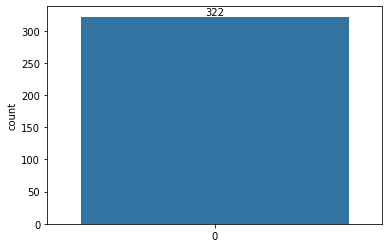

In [ ]:
ax = sns.countplot(labels)
ax.bar_label(ax.containers[0])

In [ ]:
df['CLASS'].value_counts()

0    207
1    123
Name: CLASS, dtype: int64

In [ ]:
labels.head(), np.array(labels).shape

(0    1
 1    1
 2    0
 3    0
 4    1
 Name: CLASS, dtype: int64, (322,))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive")

In [ ]:
!tar -xvf all-mias.tar.gz -C /content/drive/MyDrive/

Info.txt
Licence.txt
README
mdb001.pgm
mdb002.pgm
mdb003.pgm
mdb004.pgm
mdb005.pgm
mdb006.pgm
mdb007.pgm
mdb008.pgm
mdb009.pgm
mdb010.pgm
mdb011.pgm
mdb012.pgm
mdb013.pgm
mdb014.pgm
mdb015.pgm
mdb016.pgm
mdb017.pgm
mdb018.pgm
mdb019.pgm
mdb020.pgm
mdb021.pgm
mdb022.pgm
mdb023.pgm
mdb024.pgm
mdb025.pgm
mdb026.pgm
mdb027.pgm
mdb028.pgm
mdb029.pgm
mdb030.pgm
mdb031.pgm
mdb032.pgm
mdb033.pgm
mdb034.pgm
mdb035.pgm
mdb036.pgm
mdb037.pgm
mdb038.pgm
mdb039.pgm
mdb040.pgm
mdb041.pgm
mdb042.pgm
mdb043.pgm
mdb044.pgm
mdb045.pgm
mdb046.pgm
mdb047.pgm
mdb048.pgm
mdb049.pgm
mdb050.pgm
mdb051.pgm
mdb052.pgm
mdb053.pgm
mdb054.pgm
mdb055.pgm
mdb056.pgm
mdb057.pgm
mdb058.pgm
mdb059.pgm
mdb060.pgm
mdb061.pgm
mdb062.pgm
mdb063.pgm
mdb064.pgm
mdb065.pgm
mdb066.pgm
mdb067.pgm
mdb068.pgm
mdb069.pgm
mdb070.pgm
mdb071.pgm
mdb072.pgm
mdb073.pgm
mdb074.pgm
mdb075.pgm
mdb076.pgm
mdb077.pgm
mdb078.pgm
mdb079.pgm
mdb080.pgm
mdb081.pgm
mdb082.pgm
mdb083.pgm
mdb084.pgm
mdb085.pgm
mdb086.pgm
mdb087.pgm
mdb088.pgm
mdb0

In [ ]:
path='/content/drive/MyDrive/mias'
images_path=[]
all_imgs = sorted(os.listdir('/content/drive/MyDrive/mias/'))
for i in all_imgs:
  images_path.append('/content/drive/MyDrive/mias/' + i)
    
# File output
d = {'Images path': images_path, 'Labels': labels}
pd.DataFrame(d).to_csv('metadata.csv')
check = pd.read_csv('metadata.csv')
print(check.head())

   Unnamed: 0                             Images path  Labels
0           0  /content/drive/MyDrive/mias/mdb001.pgm       1
1           1  /content/drive/MyDrive/mias/mdb002.pgm       1
2           2  /content/drive/MyDrive/mias/mdb003.pgm       0
3           3  /content/drive/MyDrive/mias/mdb004.pgm       0
4           4  /content/drive/MyDrive/mias/mdb005.pgm       1


## II. Prepare data

In [ ]:
from skimage import io, img_as_float32

class ToTensor3D(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image):
        image = img_as_float32(image)
        # The following two lines are to duplicate the grayscale image onto
        # 3 channels. That's to make the input compatible with those models
        # trained on color images. If you don't use pretrained models, you can
        # delete these two lines.
        new_shape = (3,) + image.shape
        dup_img = np.broadcast_to(image, new_shape)

        return torch.from_numpy(dup_img.copy())

class MIAS(Dataset):
    def __init__(self, csv_file, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def normalize(self, image):
      image = image.astype(float) * 255. / image.max()
      # Convert float --> uint8. This maps pixel intensities from 0 to 255
      # Source: above and here: https://scikit-image.org/docs/stable/user_guide/data_types.html
      image = image.astype(np.uint8)
      return image

    def __getitem__(self, idx):
        img_path = self.img_labels['Images path'][idx]
        image_og = cv2.imread(img_path, 0)
        label = self.img_labels['Labels'][idx]

        # Normalize image
        image = self.normalize(image_og)

        # Convert to 3D tensor
        t = ToTensor3D()
        image = t(image)

        if self.transform:
            image = self.transform(image)
        return image, label
       
labels_path = 'metadata.csv'
transform1 = transforms.Compose([transforms.ToPILImage(),
                                 transforms.ToTensor(), 
                                 transforms.Resize((224,224)),
                                 transforms.RandomHorizontalFlip(1),
                                 transforms.RandomRotation(10),
                                 # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                 torchvision.transforms.Grayscale(num_output_channels=3),
                                 # transforms.ToTensor(), 
                                ])
transform2 = transforms.Compose([transforms.ToPILImage(),
                                 transforms.ToTensor(),
                                 transforms.Resize((224,224)),
                                 # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                 torchvision.transforms.Grayscale(num_output_channels=3),
                                 # transforms.ToTensor(),
                                 ])

transformed = MIAS(labels_path, transform = transform1)
original = MIAS(labels_path, transform = transform2)
full_dataset = ConcatDataset([transformed, original])

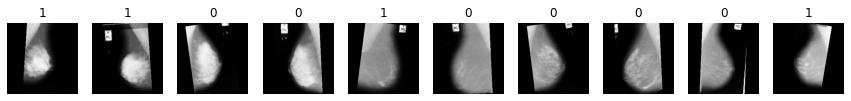

In [ ]:
plt.figure(figsize=(15, 15))
for idx, (img, label) in enumerate(full_dataset):
    # print(img.shape) #1 224 224 
    # print(img.permute(1, 2, 0).shape, label) #224 224 1
    plt.subplot(1,10,idx+1)
    # print(img.size())
    plt.imshow(img.permute(1,2,0)) # .squeeze()
    plt.axis('off')
    plt.title(label)
    if idx == 9:
        break

### I. Dataloader

In [ ]:
# FOR WEIGHTED SAMPLER !!
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

orig_train_dataset = CustomImageDataset('mias', traindf, transform=data_transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Weighted sampler
y_train = [orig_train_dataset.df.loc[i]["label_num"] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Remake the train dataloader
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=Config.batch_size,
                          num_workers=Config.numworkers)
val_loader = torch.utils.data.DataLoader(test_dataset, Config.batch_size, 
                                         shuffle=True, num_workers=Config.numworkers)

NameError: ignored

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


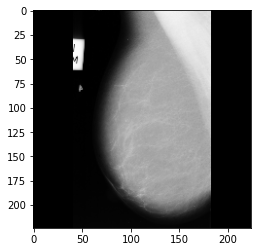

Label: 0
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


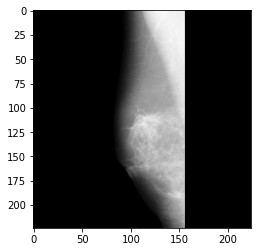

Label: 0
Using device:  cuda:0


In [ ]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # .squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray") # , cmap="gray"
plt.show()
print(f"Label: {label}")

# Putting these into a dict format for easier use later
dataloaders = {"train": train_dataloader,
               "val": test_dataloader
               }

dataset_sizes = {"train": len(train_dataset),
                 "val": len(test_dataset)
                 }
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # .squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray") # , cmap="gray"
plt.show()
print(f"Label: {label}")

# Run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from torchvision.models import resnet50, ResNet50_Weights

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# losses and accuracies
epoch_ls = []
train_loss_ls = []
val_loss_ls = []
train_acc_ls = []
val_acc_ls = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Book-keep metrics
            if phase == 'train':
              epoch_ls.append(epoch)
              train_loss_ls.append(epoch_loss)
              train_acc_ls.append(epoch_acc)
              

            if phase == "val":
              val_loss_ls.append(epoch_loss)
              val_acc_ls.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Fine tune
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train and eval
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1134 Acc: 0.5184
val Loss: 0.7921 Acc: 0.6047

Epoch 1/24
----------
train Loss: 0.6676 Acc: 0.6136
val Loss: 0.6832 Acc: 0.6047

Epoch 2/24
----------
train Loss: 0.6720 Acc: 0.6524
val Loss: 0.7366 Acc: 0.4264

Epoch 3/24
----------
train Loss: 0.6890 Acc: 0.5146
val Loss: 0.7211 Acc: 0.6047

Epoch 4/24
----------
train Loss: 0.6243 Acc: 0.6524
val Loss: 0.6624 Acc: 0.6047

Epoch 5/24
----------
train Loss: 0.5800 Acc: 0.6932
val Loss: 0.7530 Acc: 0.6047

Epoch 6/24
----------
train Loss: 0.5845 Acc: 0.6680
val Loss: 0.6851 Acc: 0.6124

Epoch 7/24
----------
train Loss: 0.5512 Acc: 0.8078
val Loss: 0.6688 Acc: 0.6124

Epoch 8/24
----------
train Loss: 0.5168 Acc: 0.7515
val Loss: 0.7057 Acc: 0.5969

Epoch 9/24
----------
train Loss: 0.5277 Acc: 0.6932
val Loss: 0.7279 Acc: 0.6047

Epoch 10/24
----------
train Loss: 0.5164 Acc: 0.6913
val Loss: 0.7168 Acc: 0.6047

Epoch 11/24
----------
train Loss: 0.5124 Acc: 0.7184
val Loss: 0.7002 Acc: 0.6124

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML4BDS2023/Hackathon_ImageNet_PT_ResNet50_SGD_MIAS.pt')

NameError: ignored

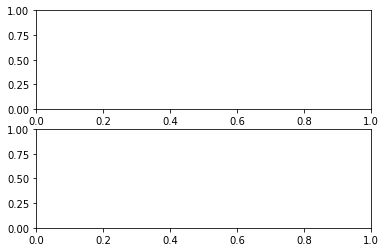

In [ ]:
# Initialize subplots
import matplotlib.pyplot as plt
figure, axis = plt.subplots(2, 1)

# Plot
import matplotlib.pyplot as plt
axis[0].plot(epoch_ls, train_loss_ls, '.r--', label='Train Loss')
axis[0].plot(epoch_ls, val_loss_ls, '.b-', label='Validation Loss')
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_title("Train versus Validation Loss")
axis[0].legend()

axis[1].plot(epoch_ls, train_acc_ls, '.r--', label='Train Accuracy')
axis[1].plot(epoch_ls, val_acc_ls, '.b-', label='Validation Accuracy')
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].set_title("Train versus Validation Accuracy")
axis[1].legend()

# Apply labels 
plt.tight_layout()
plt.show()

In [ ]:
# Clone project git repo
!git clone https://github.com/chrisporras/graddiss.git

Cloning into 'graddiss'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 44 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), 443.77 KiB | 529.00 KiB/s, done.


In [ ]:
# install Kaggle public api
! pip install -q kaggle
# Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
! cp ./graddiss/kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json
#Change the permissions of the file.
! kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2248         92  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14           1129         35  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                      8KB  2023-02-01 12:22:51          13938        467  1.0              
datascientistanna/customers-dataset          

In [ ]:
!kaggle competitions download -c mammography-image-patch-classification-2023
# data directory
!mkdir data
# unzip data there,
!unzip mammography-image-patch-classification-2023.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train_imgs/P000435.png  
  inflating: data/train_imgs/P000436.png  
  inflating: data/train_imgs/P000437.png  
  inflating: data/train_imgs/P000438.png  
  inflating: data/train_imgs/P000439.png  
  inflating: data/train_imgs/P000440.png  
  inflating: data/train_imgs/P000441.png  
  inflating: data/train_imgs/P000442.png  
  inflating: data/train_imgs/P000443.png  
  inflating: data/train_imgs/P000444.png  
  inflating: data/train_imgs/P000445.png  
  inflating: data/train_imgs/P000446.png  
  inflating: data/train_imgs/P000447.png  
  inflating: data/train_imgs/P000448.png  
  inflating: data/train_imgs/P000449.png  
  inflating: data/train_imgs/P000450.png  
  inflating: data/train_imgs/P000451.png  
  inflating: data/train_imgs/P000452.png  
  inflating: data/train_imgs/P000453.png  
  inflating: data/train_imgs/P000454.png  
  inflating: data/train_imgs/P000455.png  
  inflating: data/train_imgs/P000456.png  
  i

In [ ]:
# Configuration class
class Config:
    resize = False
    batch_size = 64
    numworkers = 2

In [ ]:
# CustomImageDataset class
import numpy as np
import os
import torch
from PIL import Image
import torchvision
from skimage import io, img_as_float32
import numpy as np
import torch
from skimage.io import imread

class ToTensor3D(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image):
        image = img_as_float32(image)
        # The following two lines are to duplicate the grayscale image onto
        # 3 channels. That's to make the input compatible with those models
        # trained on color images. If you don't use pretrained models, you can
        # delete these two lines.
        new_shape = (3,) + image.shape
        dup_img = np.broadcast_to(image, new_shape)

        return torch.from_numpy(dup_img.copy())

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, transform=None):
        # Create one iterable that get be __getitemed__
        self.image_dir = image_dir
        self.df = df
        self.transform = transform # added transform

    def __len__(self): # Denotes the total number of samples
        # return self.df.shape[0] # orig
        return len(self.df) # try this

    # added this for normalization: https://towardsdatascience.com/train-a-neural-network-to-detect-breast-mri-tumors-with-pytorch-250a02be7777
    def normalize(self, image):
      image = image.astype(float) * 255. / image.max()
      # Convert float --> uint8. This maps pixel intensities from 0 to 255
      # Source: above and here: https://scikit-image.org/docs/stable/user_guide/data_types.html
      image = image.astype(np.uint8)
      return image

    def __getitem__(self, index): # Generates one sample of data
        
        # added this
        if torch.is_tensor(index):
          index = index.tolist()

        # Goes to image_tensor below
        image_path = os.path.join(self.image_dir, self.df.iloc[index]['img_name'])
        # image_og = Image.open(image_path)
        image_og = imread(image_path) # read in png or jpg

        # Normalize image
        image = self.normalize(image_og)

        # Convert to 3D tensor
        t = ToTensor3D()
        image = t(image)

        if self.transform:
          image = self.transform(image)
          # image = self.transform(image_og)

        label = torch.tensor(self.df.iloc[index]['label_num']) 

        # Resize, depending on the network
        if Config.resize:
            resize = torchvision.transforms.Resize(384)
            image = resize(image)
        
        return image, label

In [ ]:
import pandas as pd

# New numeric labels.
labels_num = {'background': 0, 'calc_ben': 1, 'calc_mal': 2, 'mass_ben': 3, 'mass_mal': 4}

# Create datasets
traindf = pd.read_csv('data/train.csv') 
traindf['label_num'] = traindf['label'].map(labels_num)
train_dataset = CustomImageDataset('data/train_imgs', traindf)
testdf = pd.read_csv('data/test.csv') 

print(traindf.head())

        id     label     img_name  label_num
0  P000001  calc_ben  P000001.png          1
1  P000002  calc_ben  P000002.png          1
2  P000003  mass_ben  P000003.png          3
3  P000004  mass_mal  P000004.png          4
4  P000005  calc_mal  P000005.png          2


In [ ]:
from torchvision import datasets, transforms

# Define transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Some data augmentation
    transforms.RandomHorizontalFlip(), # Some data augmentation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
# from tqdm import tqdm

orig_train_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms)
train_size = int(0.5 * len(orig_train_dataset))
val_size = len(orig_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(orig_train_dataset, 
                                                     [train_size, val_size])

# Addressing class imbalance by weighting samples 
# Shen: The sample weights were adjusted within each batch to balance the five classes.
y_train = [orig_train_dataset.df.loc[i]["label_num"] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Remake the train dataloader
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=Config.batch_size,
                          num_workers=Config.numworkers)
val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
                                         shuffle=True, num_workers=Config.numworkers)

# Build batches - check distribution of classes per batch
'''for step, (img,label) in enumerate(train_loader):
  print("batch index {}, 0/1/2/3/4: {}/{}/{}/{}/{}".format(step,
                                                           len(np.where(label.numpy() == 0)[0]),
                                                           len(np.where(label.numpy() == 1)[0]),
                                                           len(np.where(label.numpy() == 2)[0]),
                                                           len(np.where(label.numpy() == 3)[0]),
                                                           len(np.where(label.numpy() == 4)[0]))
  )'''


# Putting these into a dict format for easier use later
dataloaders = {"train": train_loader,
               "val": val_loader
               }

dataset_sizes = {"train": len(train_dataset),
                 "val": len(val_dataset)
                 }
# Run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from torchvision.models import resnet50, ResNet50_Weights

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
model_conv = resnet50(num_classes=5)  
checkpoint = torch.load('/content/drive/MyDrive/ML4BDS2023/Hackathon_ImageNet_PT_ResNet50_SGD_MIAS.pt')
model_conv.load_state_dict(checkpoint)

for param in model_conv.parameters():
    param.requires_grad = False

In [ ]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs (but not used)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

# Train model
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5326 Acc: 0.3235
val Loss: 1.3268 Acc: 0.4936

Epoch 1/24
----------
train Loss: 1.4472 Acc: 0.3953
val Loss: 1.2787 Acc: 0.5101

Epoch 2/24
----------
train Loss: 1.3951 Acc: 0.4199
val Loss: 1.2942 Acc: 0.4954

Epoch 3/24
----------
train Loss: 1.3698 Acc: 0.4431
val Loss: 1.3394 Acc: 0.4741

Epoch 4/24
----------
train Loss: 1.3654 Acc: 0.4244
val Loss: 1.2485 Acc: 0.4950

Epoch 5/24
----------
train Loss: 1.3331 Acc: 0.4464
val Loss: 1.1888 Acc: 0.5300

Epoch 6/24
----------
train Loss: 1.3187 Acc: 0.4553
val Loss: 1.2099 Acc: 0.5237

Epoch 7/24
----------
train Loss: 1.2973 Acc: 0.4663
val Loss: 1.2205 Acc: 0.5208

Epoch 8/24
----------
train Loss: 1.3032 Acc: 0.4674
val Loss: 1.2219 Acc: 0.5274

Epoch 9/24
----------
train Loss: 1.3205 Acc: 0.4579
val Loss: 1.1782 Acc: 0.5370

Epoch 10/24
----------
train Loss: 1.2818 Acc: 0.4689
val Loss: 1.2182 Acc: 0.5193

Epoch 11/24
----------
train Loss: 1.2642 Acc: 0.4840
val Loss: 1.2003 Acc: 0.5322

Ep